In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import clip
from PIL import Image
import clip
import numpy as np

# Few Shot 

In this experiment, we will train multiple classifiers (MLP, SVM and Logistic Regression models) and compare their results. Also, we will reduce the dimensions of the encoded images and aim to see separate clusters.

# Load Model

In [4]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

Let's opt for simplicity and start with the smallest ResNet model (50)

In [5]:
name = 'RN50'
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

model, preprocess = clip.load(name, device=device, jit=False)

device: cuda


In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa703b13790>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Load Data

## DataLoaders

In [7]:
from dataset import CocoCaseStudyDataset
from torch.utils.data import DataLoader
from torchvision import transforms

np.random.seed(0)

transform = transforms.Compose([
    transforms.Resize((224,224,)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

train_dataset = CocoCaseStudyDataset(split='train', experiment_type='few', transform=transform)
test_dataset = CocoCaseStudyDataset(split='test', experiment_type='few', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
len(train_dataset), len(test_dataset)

(234, 503)

## Visualize Inputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


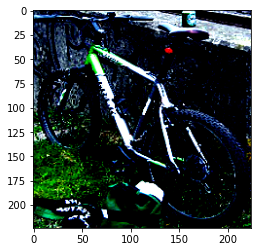

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


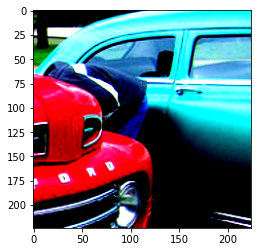

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


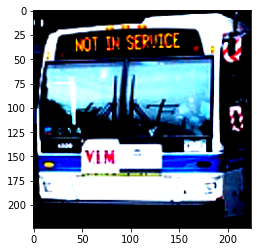

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


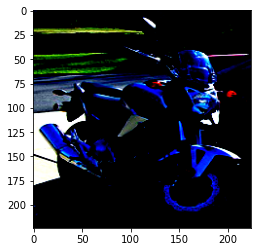

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


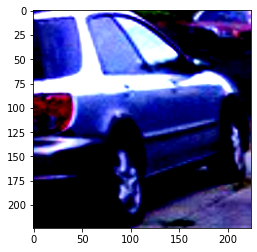

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


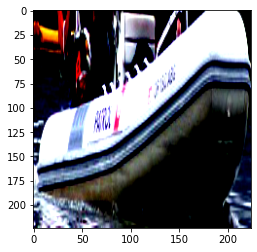

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


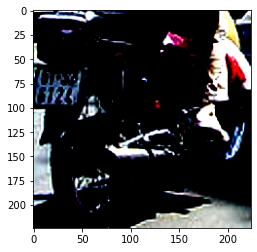

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


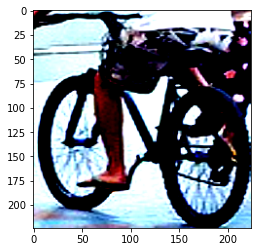

In [9]:
import matplotlib.pyplot as plt

# Transformed model inputs, not original pictures
# Important Note: Center crop that comes from the original transformation of the CLIP is replaced
# by resize method because we observed the objects in the current dataset can disappear due to center crop.

for batch_ndx, (image, cls) in enumerate(train_dataloader):
    plt.imshow(image[0].permute(1,2,0))
    plt.show()

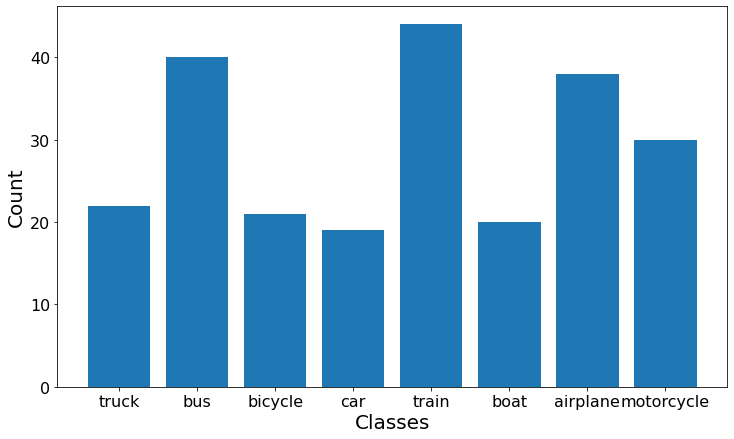

In [10]:
# Class Histograms

class_counts = train_dataset.get_class_counts()

plt.figure(figsize=(12,7))
plt.bar(class_counts.keys(), list(class_counts.values()))  # density=False would make counts
plt.ylabel('Count', fontsize=20)
plt.xlabel('Classes', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Training

In [12]:
training_encodings = []
training_classes = []

for batch_ndx, (image, cls) in enumerate(train_dataloader):
    training_encoded_img = model.encode_image(image.cuda()).detach().cpu().numpy()
    training_encodings.append(training_encoded_img)
    training_classes += cls

training_encodings = np.concatenate(training_encodings,axis=0)
training_encodings.shape, len(training_classes)

((234, 1024), 234)

## SVM

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

gamma = [1e-2, 1e-1, 1e0, 1e+1, 'scale', 'auto']
C = [1e-3, 1e-2,1e-1,1e-0,1e+1,1e+2]

best = 0
final_gamma = None
final_C = None
best_svm_classifier = None

for gamma_val in gamma:
    for C_val in C:
        svm = SVC(gamma=gamma_val, C=C_val)
        score = cross_val_score(svm, training_encodings, training_classes, cv=10, scoring='accuracy').mean()

        if score > best:
            best = score
            best_svm_classifier = svm
            final_gamma = gamma_val
            final_C = C_val
            
del svm
print(f'Best params: C is {final_C}, gamma is {final_gamma}')

Best params: C is 10.0, gamma is 0.1


In [31]:
# Training score
best_svm_classifier = SVC(gamma=final_gamma, C=final_C)
best_svm_classifier.fit(training_encodings, training_classes)
best_svm_classifier.score(training_encodings, training_classes)

1.0

## MLP

In [28]:
from sklearn.neural_network import MLPClassifier


lr = [1e-4,1e-3,5e-3,1e-2]
hidden_layer_sizes = [(32),(64),(128), (128,64), (64,32)]
solver = ['adam', 'sgd']
batch_size = [16,32,64]

best_lr = None
best_hidden_layer_sizes = None
best_solver = None
best_batch_size = None

best = 0
best_mlp_classifier = None

for lr_val in lr:
    for hidden_val in hidden_layer_sizes:
        for solver_val in solver:
            for batch_size_val in batch_size:
                
                mlp = MLPClassifier(
                    hidden_layer_sizes=hidden_val,
                    solver=solver_val,
                    batch_size=batch_size_val, 
                    learning_rate_init=lr_val
                )
                score = cross_val_score(mlp, training_encodings, training_classes, cv=10, scoring='accuracy').mean()
                
                if score > best:
                    best = score
                    best_mlp_classifier = mlp
                    
                    best_lr = lr_val
                    best_hidden_layer_sizes = hidden_val
                    best_solver = solver_val
                    best_batch_size = batch_size_val
            
del mlp
print(f"lr: {best_lr}, \n hidden layer size: {best_hidden_layer_sizes} \n solver: {best_solver} \n batch size: {best_batch_size}")

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

lr: 0.001, 
 hidden layer size: 64 
 solver: adam 
 batch size: 32


/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
best_mlp_classifier = MLPClassifier(
    hidden_layer_sizes=best_hidden_layer_sizes,
    solver=best_solver,
    batch_size=best_batch_size, 
    learning_rate_init=best_lr
)

best_mlp_classifier.fit(training_encodings, training_classes)
best_mlp_classifier.score(training_encodings, training_classes)

1.0

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

C = [1e-3, 1e-2,1e-1,5e-1,1e-0,1e+1,1e+2]
penalty = ['l1', 'l2']

best = 0
final_C = None
final_penalty = None
best_lr_classifier = None

for C_val in C:
    for penalty_val in penalty:
        lr = LogisticRegression(C=C_val, penalty=penalty_val, max_iter=1000, verbose=1)
        score = cross_val_score(lr, training_encodings, training_classes, cv=10, scoring='accuracy').mean()
        
        if score > best:
            best = score
            best_lr_classifier = lr
            final_penalty = penalty_val
            final_C = C_val
            
del lr
print(f'Best params: C is {final_C}, penalty is {final_penalty}')

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     22     28      1     0     0   4.165D-03   4.244D+02
  F =   424.38078402313880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/home/umur/anaconda3/env

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     16     20      1     0     0   7.901D-04   4.099D+02
  F =   409.94881530989471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     22     24      1     0     0   5.739D-04   3.181D+02
  F =   318.11224131488024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = n

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     38     45      1     0     0   2.405D-03   1.943D+02
  F =   194.27574372399124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the fina

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     50     56      1     0     0   1.155D-03   1.454D+02
  F =   145.38447419798672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * *

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     83     87      1     0     0   1.074D-03   4.301D+01
  F =   43.010556223644826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

At iterate   50    f=  4.45574D+01    |proj g|=  1.10064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final p

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/umur/anaconda3

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.36683D+02    |proj g|=  1.27500D+01

At iterate   50    f=  9.44174D+00    |proj g|=  1.77605D-02

At iterate  100    f=  9.43737D+00    |proj g|=  3.50703D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200    103    112      1     0     0   8.202D-05   9.437D+00
  F =   9.4373710716310306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING T

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best params: C is 10.0, penalty is l2


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [35]:
best_lr_classifier = LogisticRegression(C=final_C, penalty=penalty_val, max_iter=1000, verbose=1)

best_lr_classifier.fit(training_encodings, training_classes)
best_lr_classifier.score(training_encodings, training_classes)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


1.0

# Test

In [38]:
test_encodings = []
test_classes = []

for batch_ndx, (image, cls) in enumerate(test_dataloader):
    test_encoded_img = model.encode_image(image.cuda()).detach().cpu().numpy()
    test_encodings.append(test_encoded_img)
    test_classes += cls

test_encodings = np.concatenate(test_encodings,axis=0)
test_encodings.shape, len(test_classes)

((503, 1024), 503)

In [39]:
svm_score = best_svm_classifier.score(test_encodings, test_classes)
svm_score

0.8429423459244533

In [40]:
mlp_score = best_mlp_classifier.score(test_encodings, test_classes)
mlp_score

0.856858846918489

In [41]:
lr_score = best_lr_classifier.score(test_encodings, test_classes)
lr_score

0.8469184890656064

### Accuracy

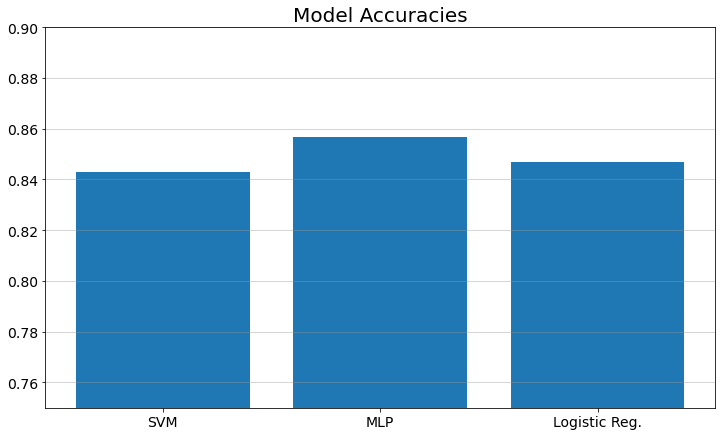

In [42]:
fig, ax = plt.subplots(figsize=(12,7))

ax.bar(['SVM', 'MLP', 'Logistic Reg.'],[svm_score, mlp_score, lr_score])
ax.set_ylim([0.75, 0.9])
ax.set_title('Model Accuracies',fontsize=20)

plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='-',alpha=0.5,color='#999999')
plt.yticks(fontsize=14)
plt.show()

### Confusion Matrix

In [43]:
from sklearn.metrics import confusion_matrix

confusion_matrix(
    y_true = test_classes,
    y_pred = best_mlp_classifier.predict(test_encodings),
    labels=np.unique(np.asarray(test_classes))
)

array([[60,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 43,  0,  0,  0,  3,  0,  0],
       [ 0,  0, 76,  0,  1,  1,  0,  1],
       [ 0,  0,  1, 63,  0,  0,  3,  2],
       [ 0,  1,  0,  1, 26,  0,  0, 19],
       [ 0,  2,  0,  0,  0, 52,  0,  0],
       [ 0,  0,  4,  2,  1,  0, 60,  0],
       [ 0,  0,  2, 21,  4,  3,  0, 51]])

The confusion matrix shows that cars are often misclassified as trucks and trucks are misclassified as buses. This misclassification occurs due to their similar shapes. The rest of the objects show promising results.

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


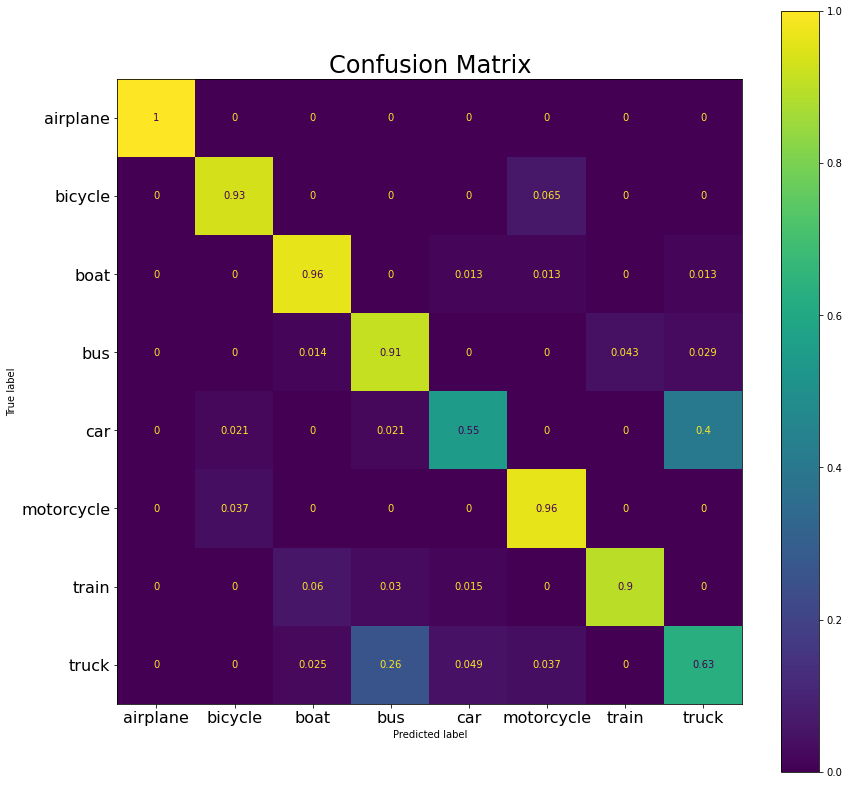

In [44]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(14, 14))
ts = 16
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
plt.title('Confusion Matrix', fontsize=24)

plot_confusion_matrix(
    best_mlp_classifier, 
    test_encodings, 
    test_classes,
    ax=ax,
    normalize='true'
)  
plt.show()

### Dimension Reduction

In [26]:
from sklearn.decomposition import PCA
pca = PCA(128)
training_embedded_encoding = pca.fit_transform(training_encodings)

np.sum(pca.explained_variance_ratio_)

0.9796004

In [27]:
test_embedded_encoding = pca.transform(test_encodings)

np.sum(pca.explained_variance_ratio_)

0.9796004

Many of the object representations in 2D group in different clusters. Although cars and trucks lie in similar distibutions and cannot be grouped clearly. At this point, this figure presents similar results as the confusion matrix.

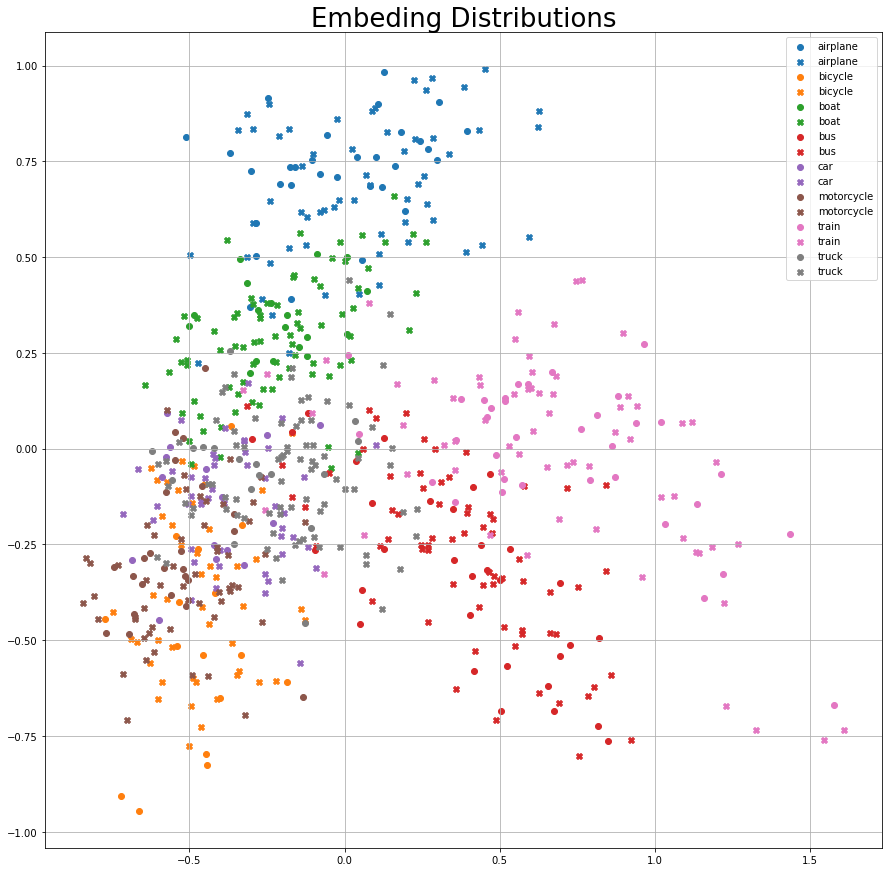

In [28]:
f, axs = plt.subplots(figsize=(15, 15))

train_classes = np.array(training_classes)
test_classes = np.array(test_classes)

colors = [f'C{i}' for i in range(len(set(train_classes)))]

for i, cls in enumerate(np.unique(np.array(train_classes))):
    training_cls_embedding = training_embedded_encoding[train_classes==cls]
    plt.scatter(training_cls_embedding[:, 0], training_cls_embedding[:, 1], label=cls, c=colors[i])
    
    test_cls_embedding = test_embedded_encoding[test_classes==cls]
    plt.scatter(test_cls_embedding[:, 0], test_cls_embedding[:, 1], label=cls, c=colors[i], marker='X')

plt.title('Embeding Distributions', fontsize=26)
plt.legend()
plt.grid()